In [1]:
%matplotlib notebook
import logging
from collections import defaultdict

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from matplotlib import cm
import scqubits as scq
from scipy.optimize import curve_fit
from quantum_builder import QuantumBuilder
import ipywidgets
import matplotlib.gridspec as gridspec
import os

plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int

cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a",  # pink salmon
    "Sky": "#00bfff",
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

R_square_room_temperature = {'Dynamic-20sccm': 6700.0, 'Static-0.4mBar': 17000, 'Static-0.25mBar': 12170.0, 'Static-0.1mBar': 5670.0, 'Static-0.13mBar': 8000}
RESISTANCE_COLD_SCALING = 1.1

def eval_expected_ej0(resistance_rt):
    EJ0 = Rq / (resistance_rt * RESISTANCE_COLD_SCALING) * Delta / 2
    return EJ0/h/GHz

def eval_resitance_from_ej0(x_side: float, y_side: float, EJ0: float):
    N_squares= x_side/100 * y_side/100
    EJ0 = EJ0 * h * GHz
    return Rq * N_squares * Delta / 2 / EJ0 / kOhm

def c_interdigitated(W: float, L: float, N: int):
    return c * N * (W + L)

def ec_interdigitated(W: float, L: float, N: int):
    C = c * N * (W + L)
    Ec = e**2 / (2 * C) / h / GHz
    return Ec

GHz = 10**9

#plt.style.use('support-files/qubit.mplstyle')

def to_dBm(array):
    # Conver to dBm. Values smaller than 0 are set to the lowest value in array
    min_value = 10 * np.log10(min(array[array > 0]))
    return 10 * np.nan_to_num(np.log10(array), nan = min_value, neginf=min_value)

def from_dBm(array):
    # Output in mW
    return np.power(10, array / 10)

def rabi_model(t, tDec, T, A, B, C, D, *args):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

def rabi_model_beating(t, t_dec, T, A, B, C, D, E, t_beat):
    """
    OLD! Need to move t_beat to the end!
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B)sin(2π t / t_beat + E) + Ct + D
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.sin(2 * np.pi * t / t_beat + E) *  np.exp(-t / t_dec) + C*t + D

In [16]:
dBm_powers = np.linspace(from_dBm(-30), from_dBm(0), 11)
for i in to_dBm(dBm_powers):
    print(i)

-30.0
-9.961088337630894
-6.972362915270183
-5.218665718994825
-3.9728905504244256
-3.0059591818466256
-2.215593164287672
-1.5471587365200847
-0.9680145295702163
-0.45709238298872995
0.0


In [9]:
from_dBm(-30)

0.001

In [11]:
from_dBm(10)

10.0

# Mfield - not done as it is the same as the one before

# Rabi oscillations at zero magnetic field bias

## Ay_03_rabi-freq-sweep_-30dBm

In [33]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_03_rabi-freq-sweep_-30dBm.txt"
# FILENAME = "./data/2021-08_photon-source/Ty_04_rabi-freq-sweep_vna0dBm.txt"
VARIABLE = "Frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f".cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


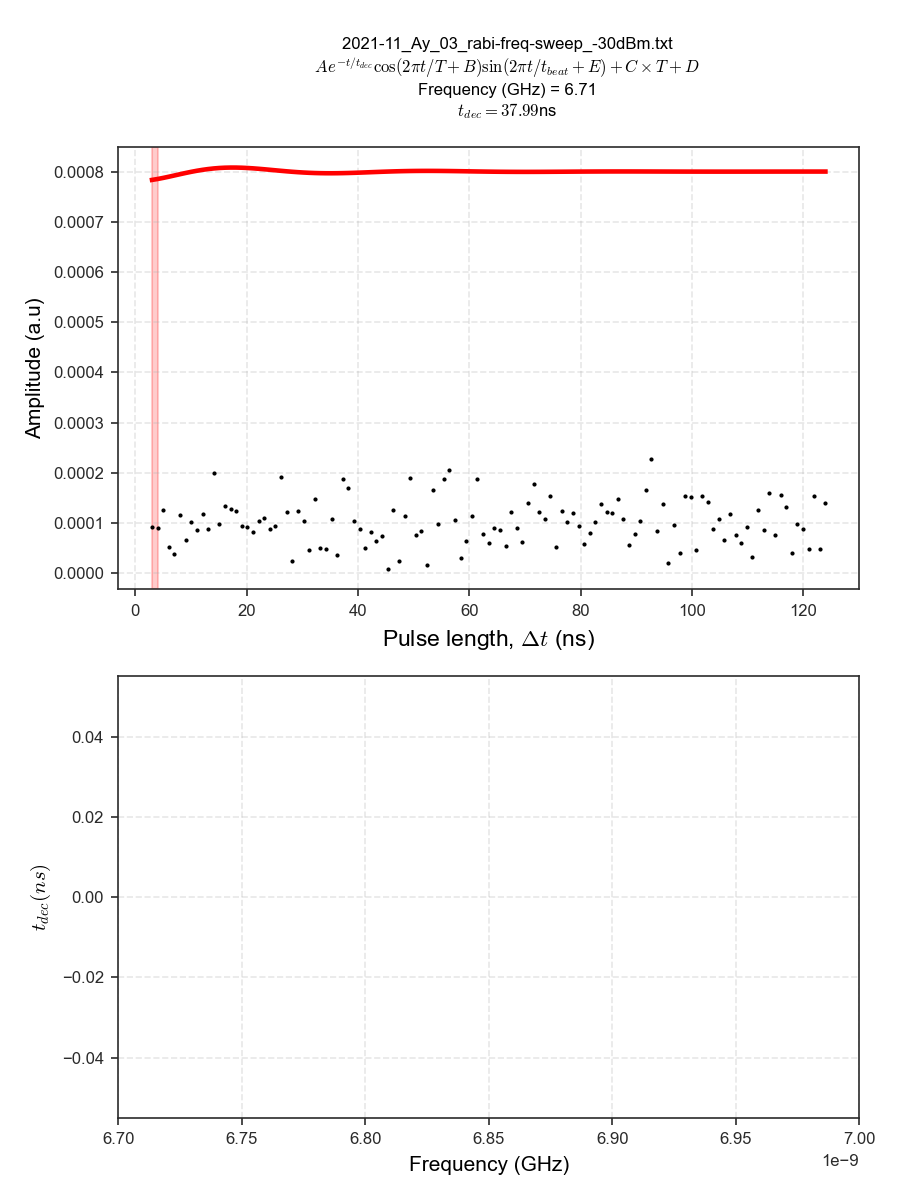

In [34]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f".cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [35]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

<IPython.core.display.Javascript object>


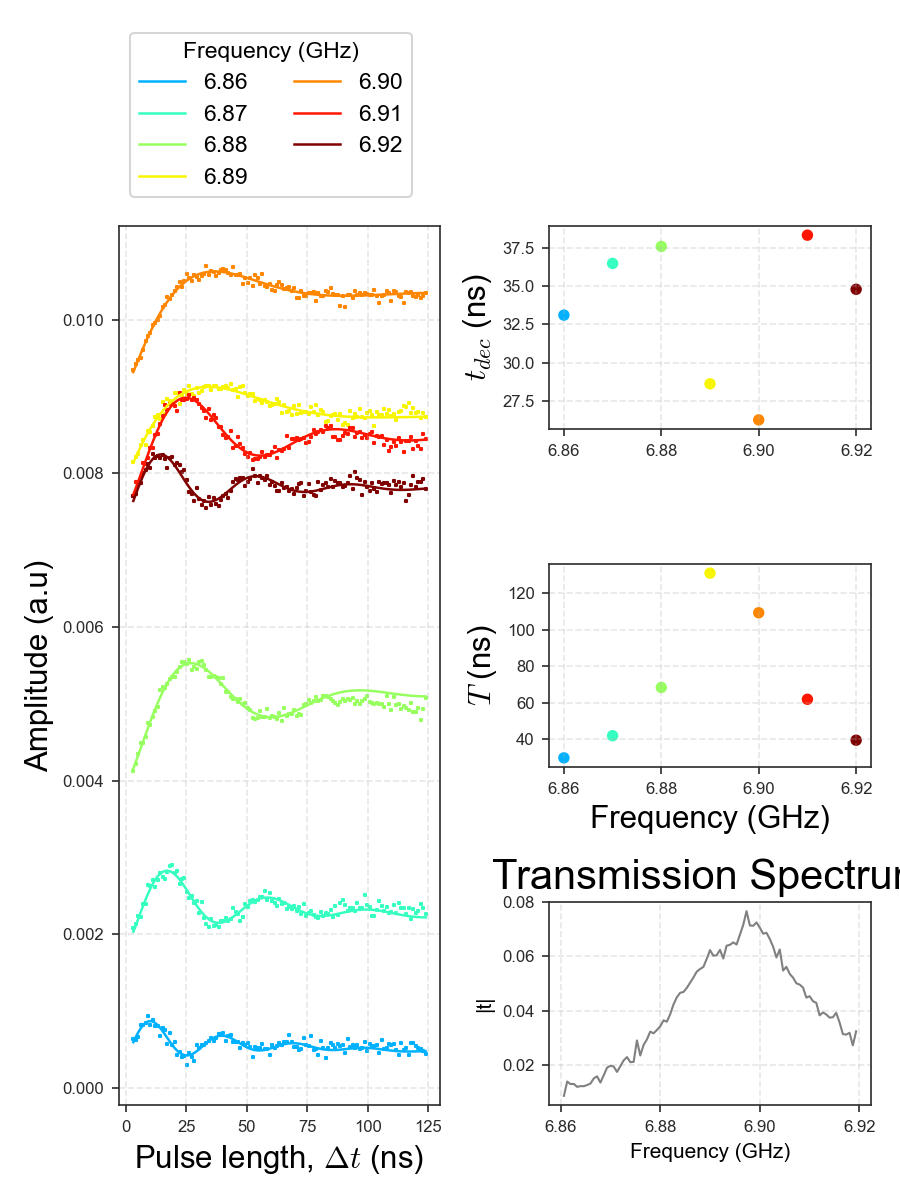

In [36]:
# Summarise the fittings:
SPACING = 0.001
cmap = plt.cm.jet(np.linspace(0.3, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_03_rabi-freq-sweep_-30dBm_transmission-spectrum.txt"

    
plt.figure(figsize=(6, 8))
# gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(121)
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=15)
ax0.set_ylabel("Amplitude (a.u)", fontsize=15)
# plt.gcf().subplots_adjust(left=0.15)
# plt.gcf().subplots_adjust(bottom=0.35)

ax1 = plt.subplot(322)
# ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=15)

ax2 = plt.subplot(324)
ax2.set_xlabel(f"{VARIABLE}", fontsize=15)
ax2.set_ylabel("$T$ (ns)", fontsize=15)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=f"{F_DATA[idx]:.2f}")
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap)

# Plot transmission
ax3 = plt.subplot(326)
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend(
    title="Frequency (GHz)",
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
    ncol = 2,
)   
plt.tight_layout()

# plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

## 2021-11_Ay_04_rabi-freq-sweep_-10dBm

In [36]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_04_rabi-freq-sweep_-10dBm.txt"
# FILENAME = "./data/2021-08_photon-source/Ty_04_rabi-freq-sweep_vna0dBm.txt"
VARIABLE = "Frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f".cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


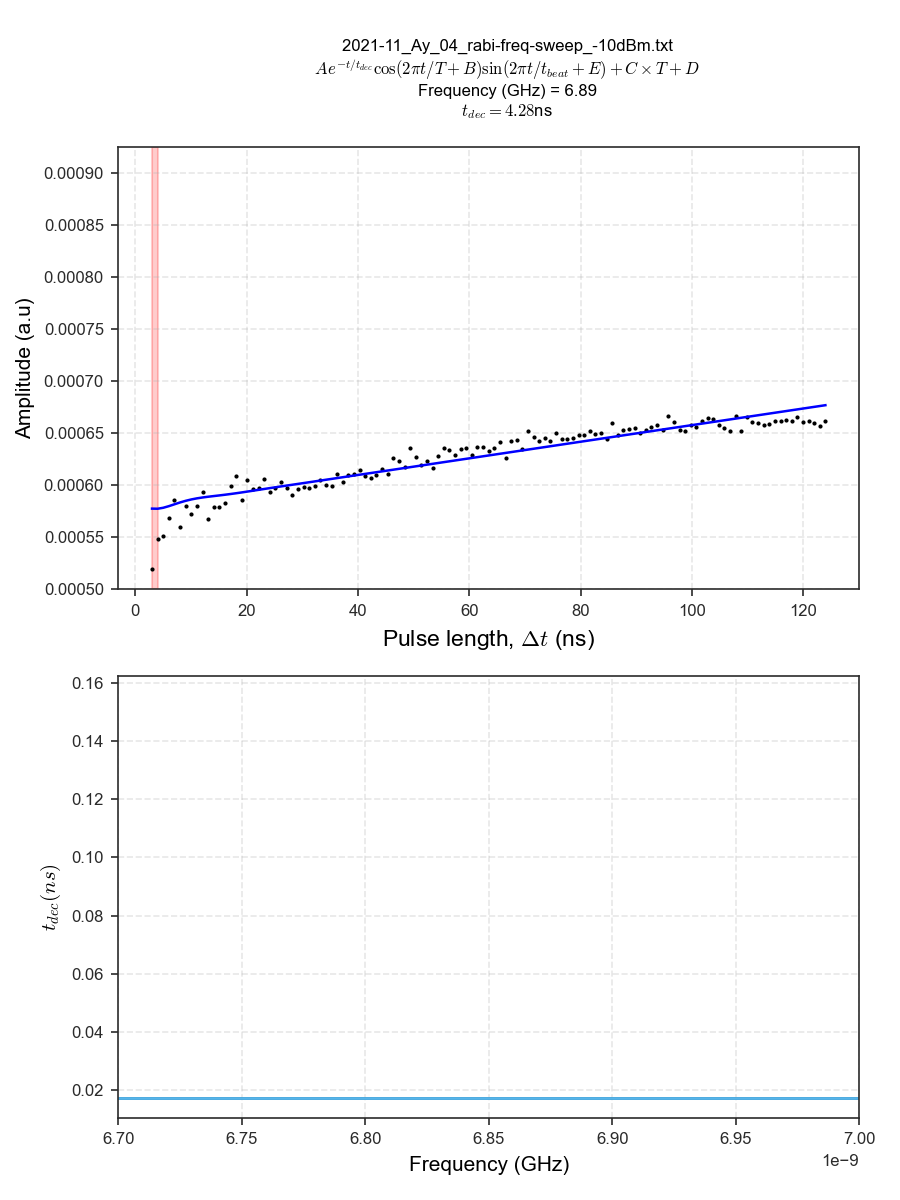

In [37]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f".cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [38]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Loaded parameters!: [17.74946469789671, 14.703490108666077, 5.8340552401460925e-05, 5.682423307357603, -1.0142021343900451e-07, 0.0002348588698057662, 1.5707963267948966, 8000.0]
Loaded parameters!: [15.626063109557338, 14.960674626284899, 8.95286488919834e-05, 5.78109143241483, -4.08651702851552e-07, 0.0002705453688862526, 1.5707963267948966, 8000.0]
Loaded parameters!: [20.437849357154228, 15.728603467377962, 8000.0, 6.10985254182518e-05, 5.496641098312781, -0.6497331385727046, 0.00031300115593763957, 1.5707963267948966]
No parameters saved for this plot
Loaded parameters!: [25.10226189729077, 15.248569800495007, 7.597402118298603e-05, 5.798252412786979, -2.120454314418625e-08, 0.0008432671659566549, 1.5707963267948966, 8000.0]


<IPython.core.display.Javascript object>


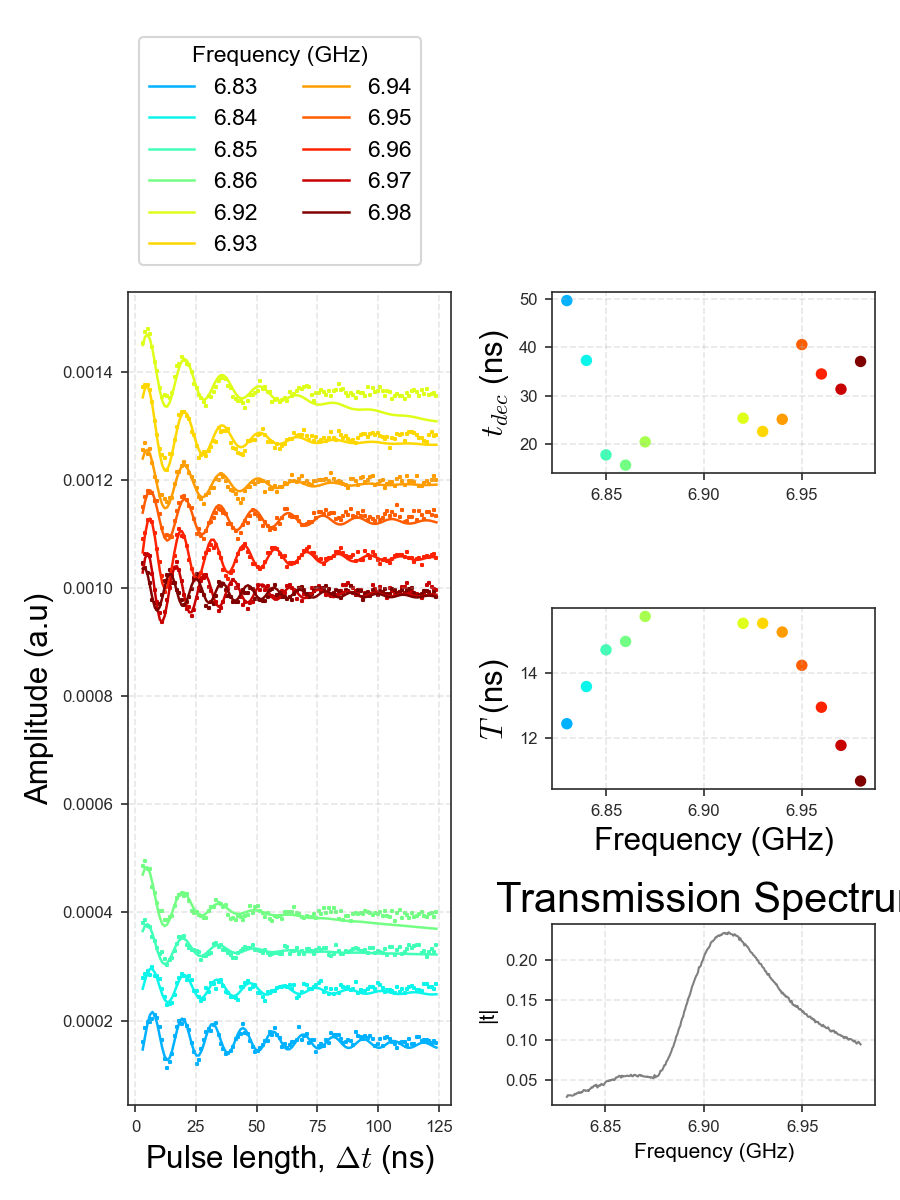

In [35]:
# Summarise the fittings:
SPACING = 0.00005
cmap = plt.cm.jet(np.linspace(0.3, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_04_rabi-freq-sweep_-10dBm_transmission-spectrum.txt"
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_04_rabi-freq-sweep_-10dBm_transmission-spectrum_using-smith18.txt"

    
plt.figure(figsize=(6, 8))
# gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(121)
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=15)
ax0.set_ylabel("Amplitude (a.u)", fontsize=15)
# plt.gcf().subplots_adjust(left=0.15)
# plt.gcf().subplots_adjust(bottom=0.35)

ax1 = plt.subplot(322)
# ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=15)

ax2 = plt.subplot(324)
ax2.set_xlabel(f"{VARIABLE}", fontsize=15)
ax2.set_ylabel("$T$ (ns)", fontsize=15)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    if F_DATA[idx] == 6.87:
        continue
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=f"{F_DATA[idx]:.2f}")
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap)

# Plot transmission
ax3 = plt.subplot(326)
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend(
    title="Frequency (GHz)",
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
    ncol = 2,
)   
plt.tight_layout()

# plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

## 2021-11_Ay_06_rabi-power-sweep

In [3]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_06_rabi-power-sweep.txt"
VARIABLE = "Power (dBm)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f".cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

In [4]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f".cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>

In [8]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

In [7]:
# Summarise the fittings:
SPACING = 0.0005
cmap = plt.cm.autumn(np.linspace(0.3, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"
    
plt.figure(figsize=(6, 8))
# gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(121)
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=15)
ax0.set_ylabel("Amplitude (a.u)", fontsize=15)
# plt.gcf().subplots_adjust(left=0.15)
# plt.gcf().subplots_adjust(bottom=0.35)

ax1 = plt.subplot(222)
# ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=15)

ax2 = plt.subplot(224)
ax2.set_xlabel(f"{VARIABLE}", fontsize=15)
ax2.set_ylabel("$T$ (ns)", fontsize=15)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap)

# Plot transmission
# ax3 = plt.subplot(gs[2, 1])
# ax3.set_title("Transmission Spectrum")
# ax3.set_xlabel(VARIABLE, fontsize=10)
# ax3.set_ylabel("|t|", fontsize=10)


# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend(
    title="dBm",
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
    ncol = 2
)   
plt.tight_layout()

# plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>

# Finding state for SPA measurements
Using the transmission spectrum, identify different "regions" and compare Rabi and incoherent oscillations

## Load transmission data

In [45]:
FILENAME = "C:/ExperimentBlue/2021-11_photon-source/2021-11_Ay_18_smith-using-chopper-at-20ns.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

transmission_profile = {
    "0dBm": data3d_z[:, 13],
    "-10dBm": data3d_z[:, 10],
    "-20dBm": data3d_z[:, 5],
    "-30dBm": data3d_z[:, 0],
}
transmission_profile_freq = data3d_y

## Load Rabi oscillations

In [49]:
rabi_oscillations = defaultdict(dict)

rabi_oscillations["0dBm"]["6.86GHz"] = 1
rabi_oscillations["0dBm"]["6.887GHz"] = 1
rabi_oscillations["0dBm"]["6.91GHz"] = 1
rabi_oscillations["0dBm"]["6.936GHz"] = 1

# rabi_oscillations[]

## Load SPA oscillation data
Here we look at the SPA result and take a slice that best demonstrates and incoherent feature (it may not exist)

<IPython.core.display.Javascript object>


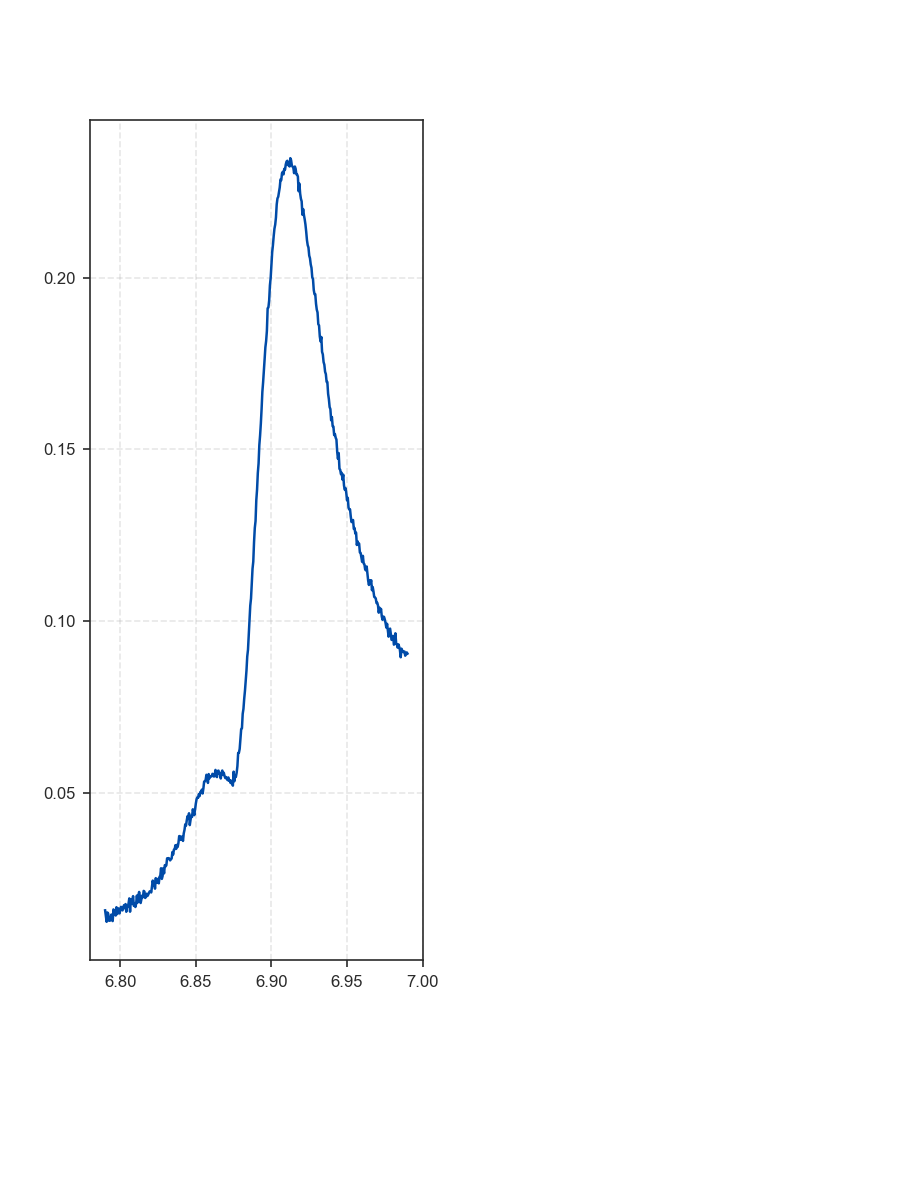

In [46]:
FILENAME = "C" 

plt.figure(figsize=(6, 8))

ax = plt.subplot(121)
ax.plot(transmission_profile_freq, transmission_profile["-10dBm"])
plt.show()

# Incoherent spectrum

## Ty_10_-2dBm_4.48GHz_25MHz

In [168]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_10_-2dBm_4.48GHz_25MHz.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


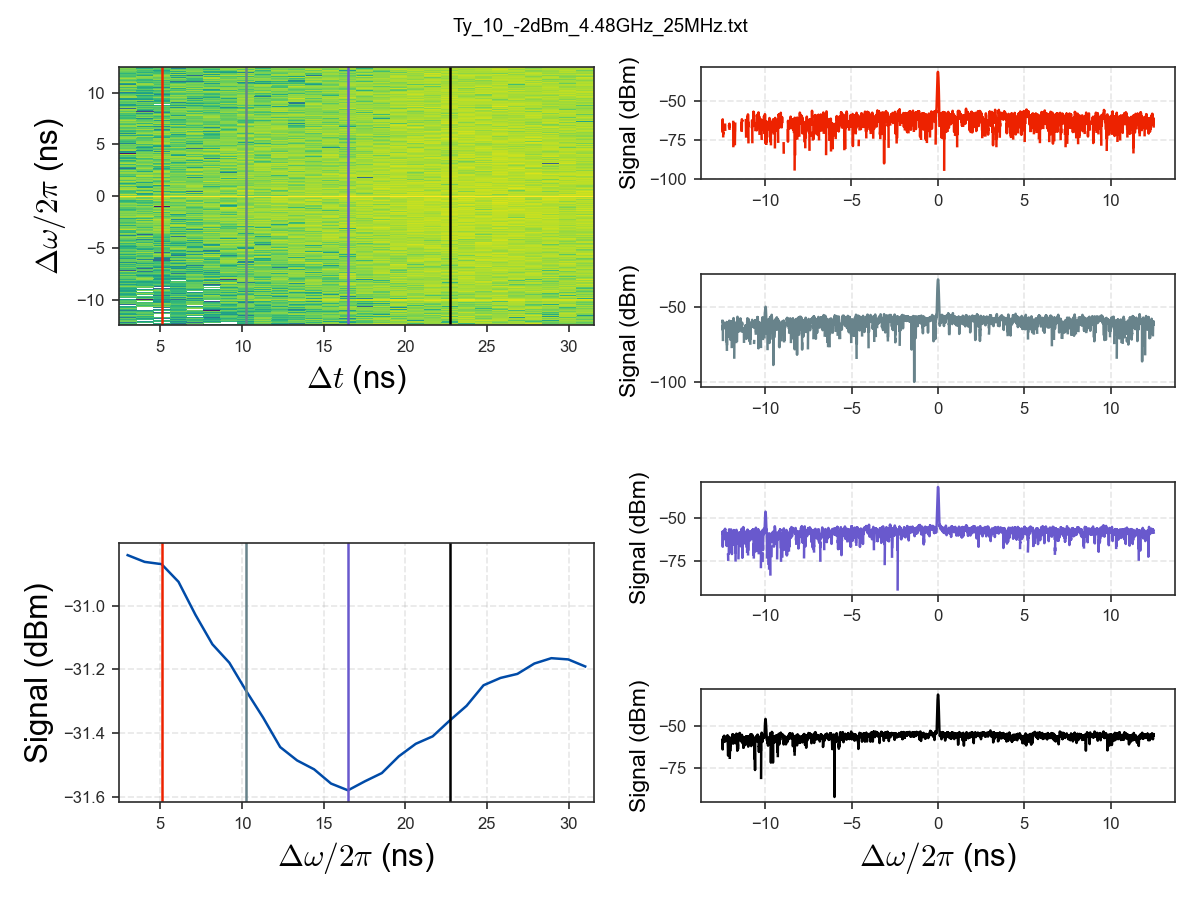

In [169]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=-50
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_10_-2dBm_4.48GHz_25MHz_stacked-amplifers

In [179]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_10_-2dBm_4.48GHz_25MHz_stacked-amplifers.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


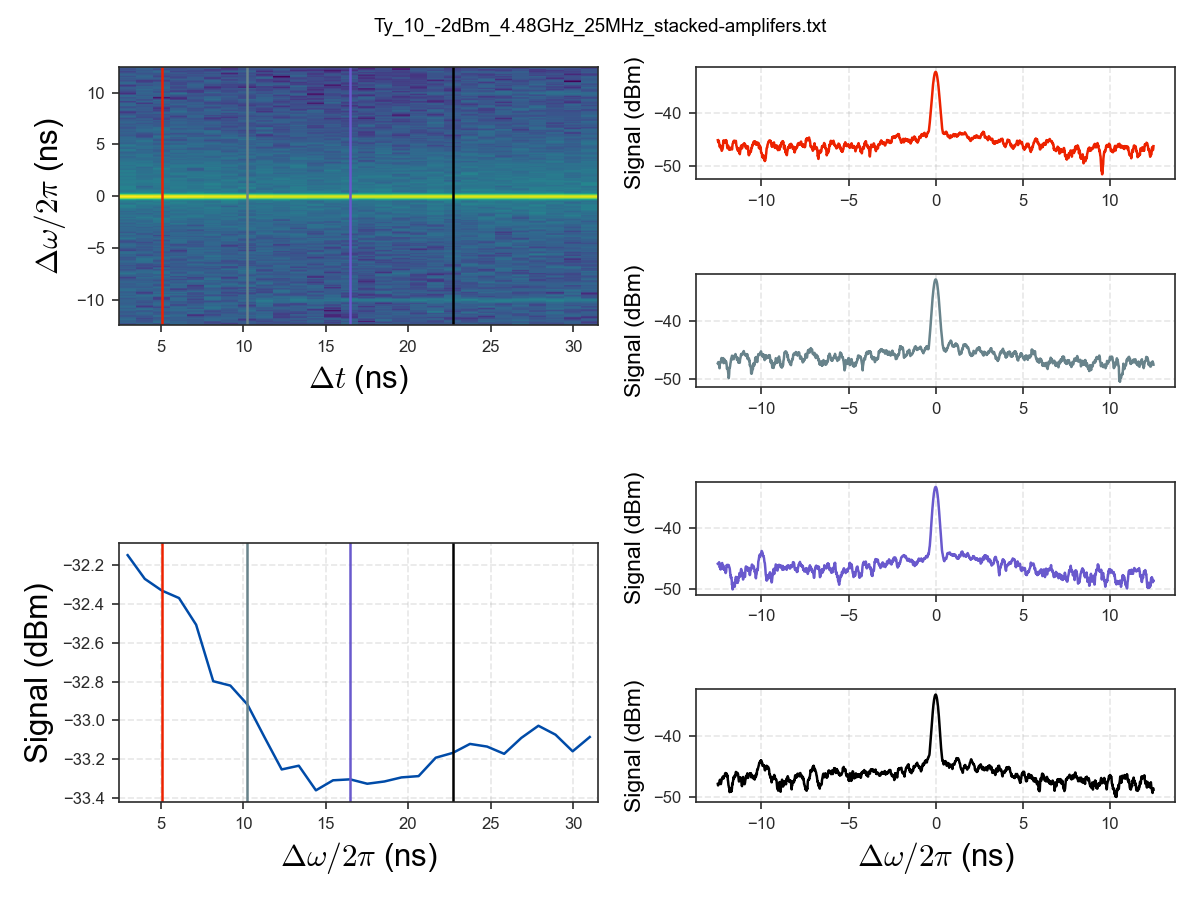

In [180]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
#               vmax=4.75*10**(-7)
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_10_5dBm_4.48GHz_40MHz

In [170]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_10_5dBm_4.48GHz_40MHz.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


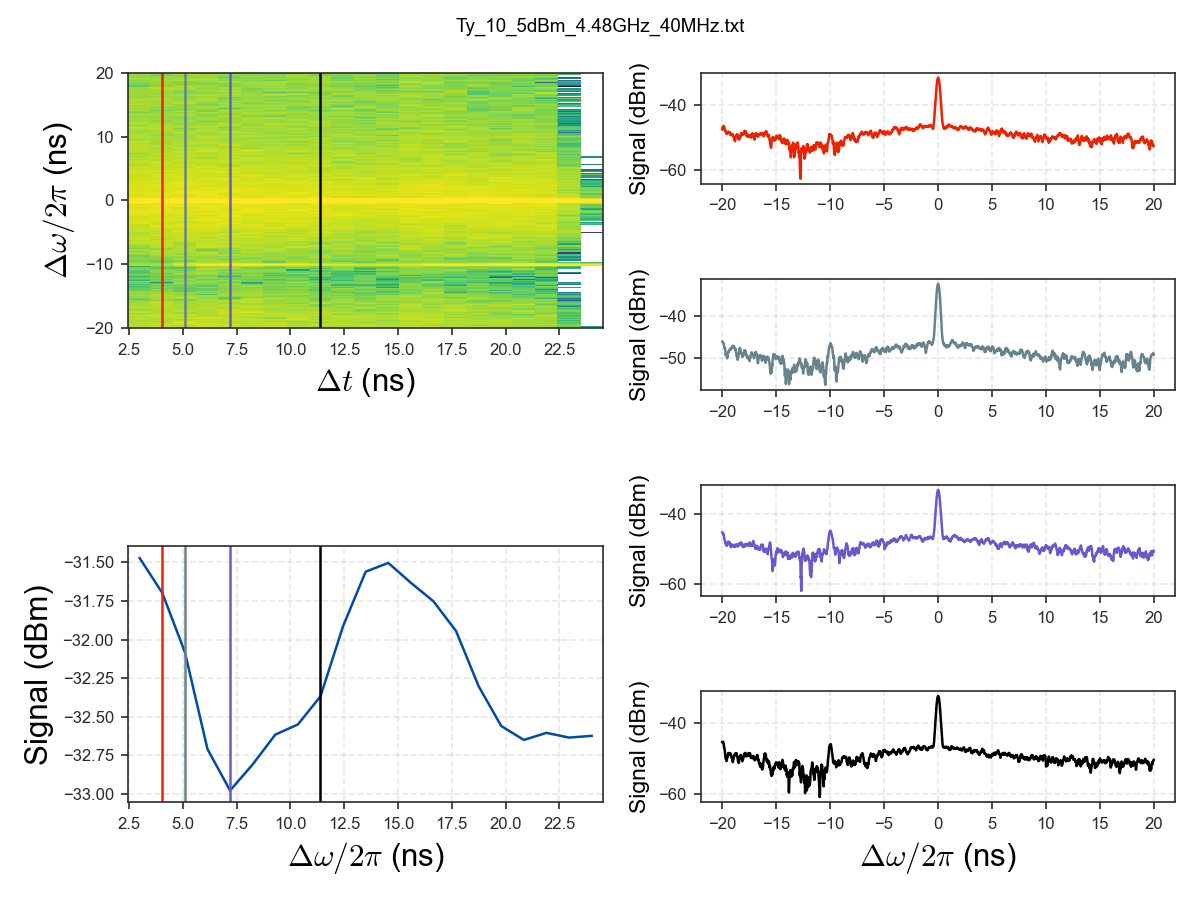

In [178]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (1, MY_COLOURS["DarkRed"]),
    (2, MY_COLOURS["LightBlue"]),
    (4, MY_COLOURS["Purple"]),
    (8, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=-45
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
# plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz

In [181]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


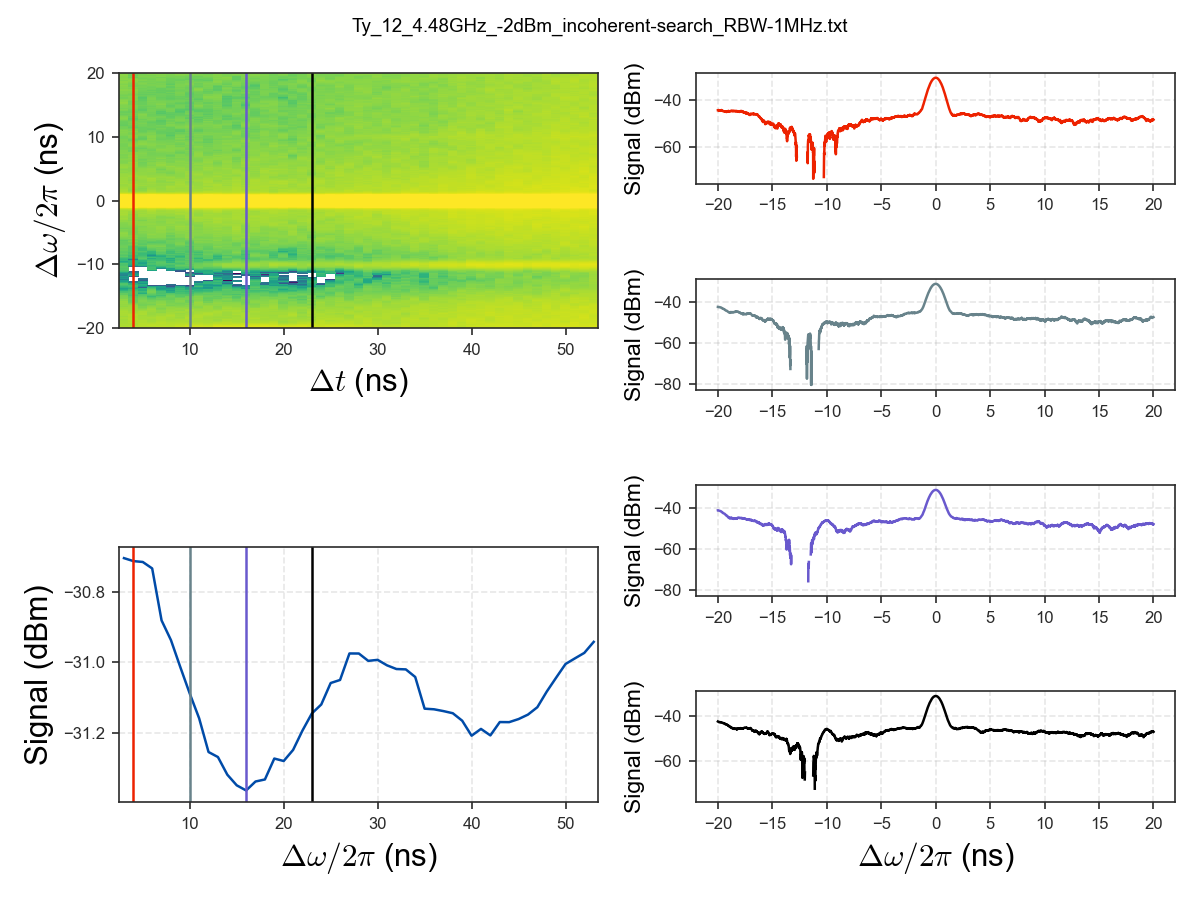

In [186]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (1, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (20, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=-40
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz_all-amplifiers

In [64]:
# FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz_all-amplifiers.txt"
FILENAME = "./data/2021-08_photon-source/Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz_all-amplifiers.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


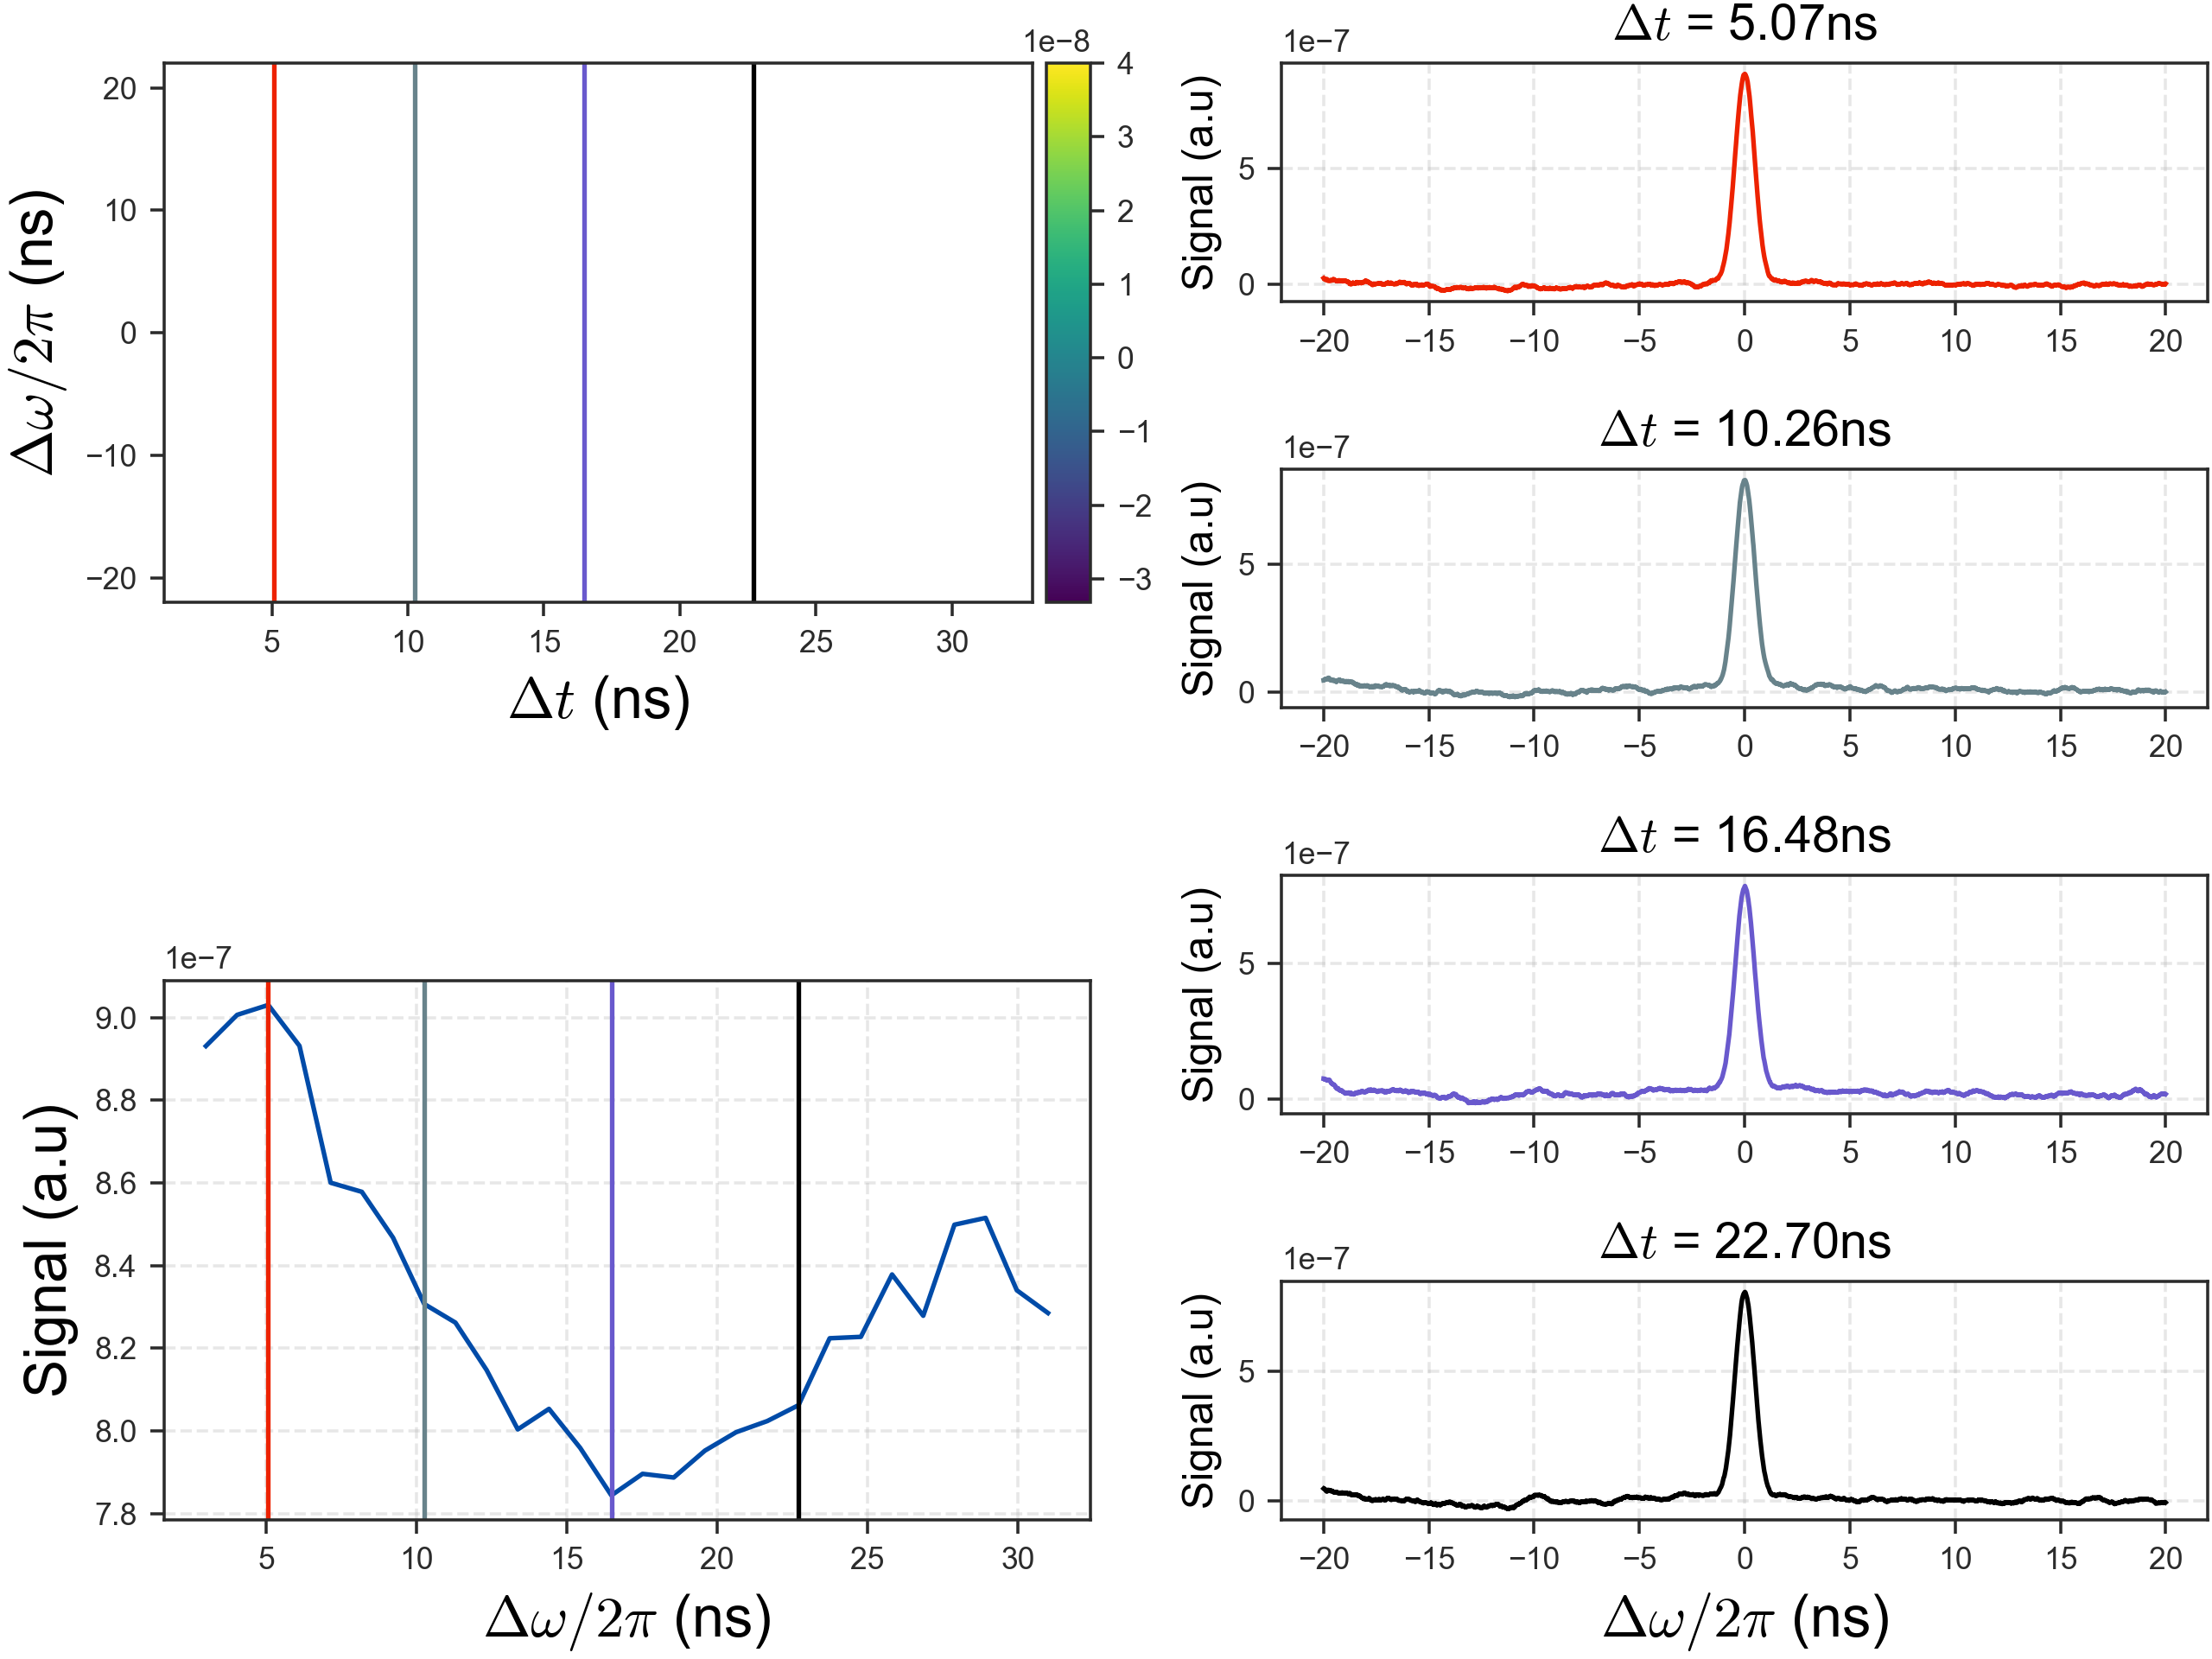

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 6))
# fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(221)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=0.4*10**(-7)
             )
fig.colorbar(im, cax=cax, orientation='vertical')
im.remove()

for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (a.u)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_title(f"$\Delta{{t}}$ = {data3d_x[idx]:.2f}ns", size=13)
    ax.set_ylabel("Signal (a.u)", fontsize=11)
    
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout(pad=0.1)
plt.savefig(FILENAME.replace("txt", "svg"), dpi=100, transparent=True)

<IPython.core.display.Javascript object>


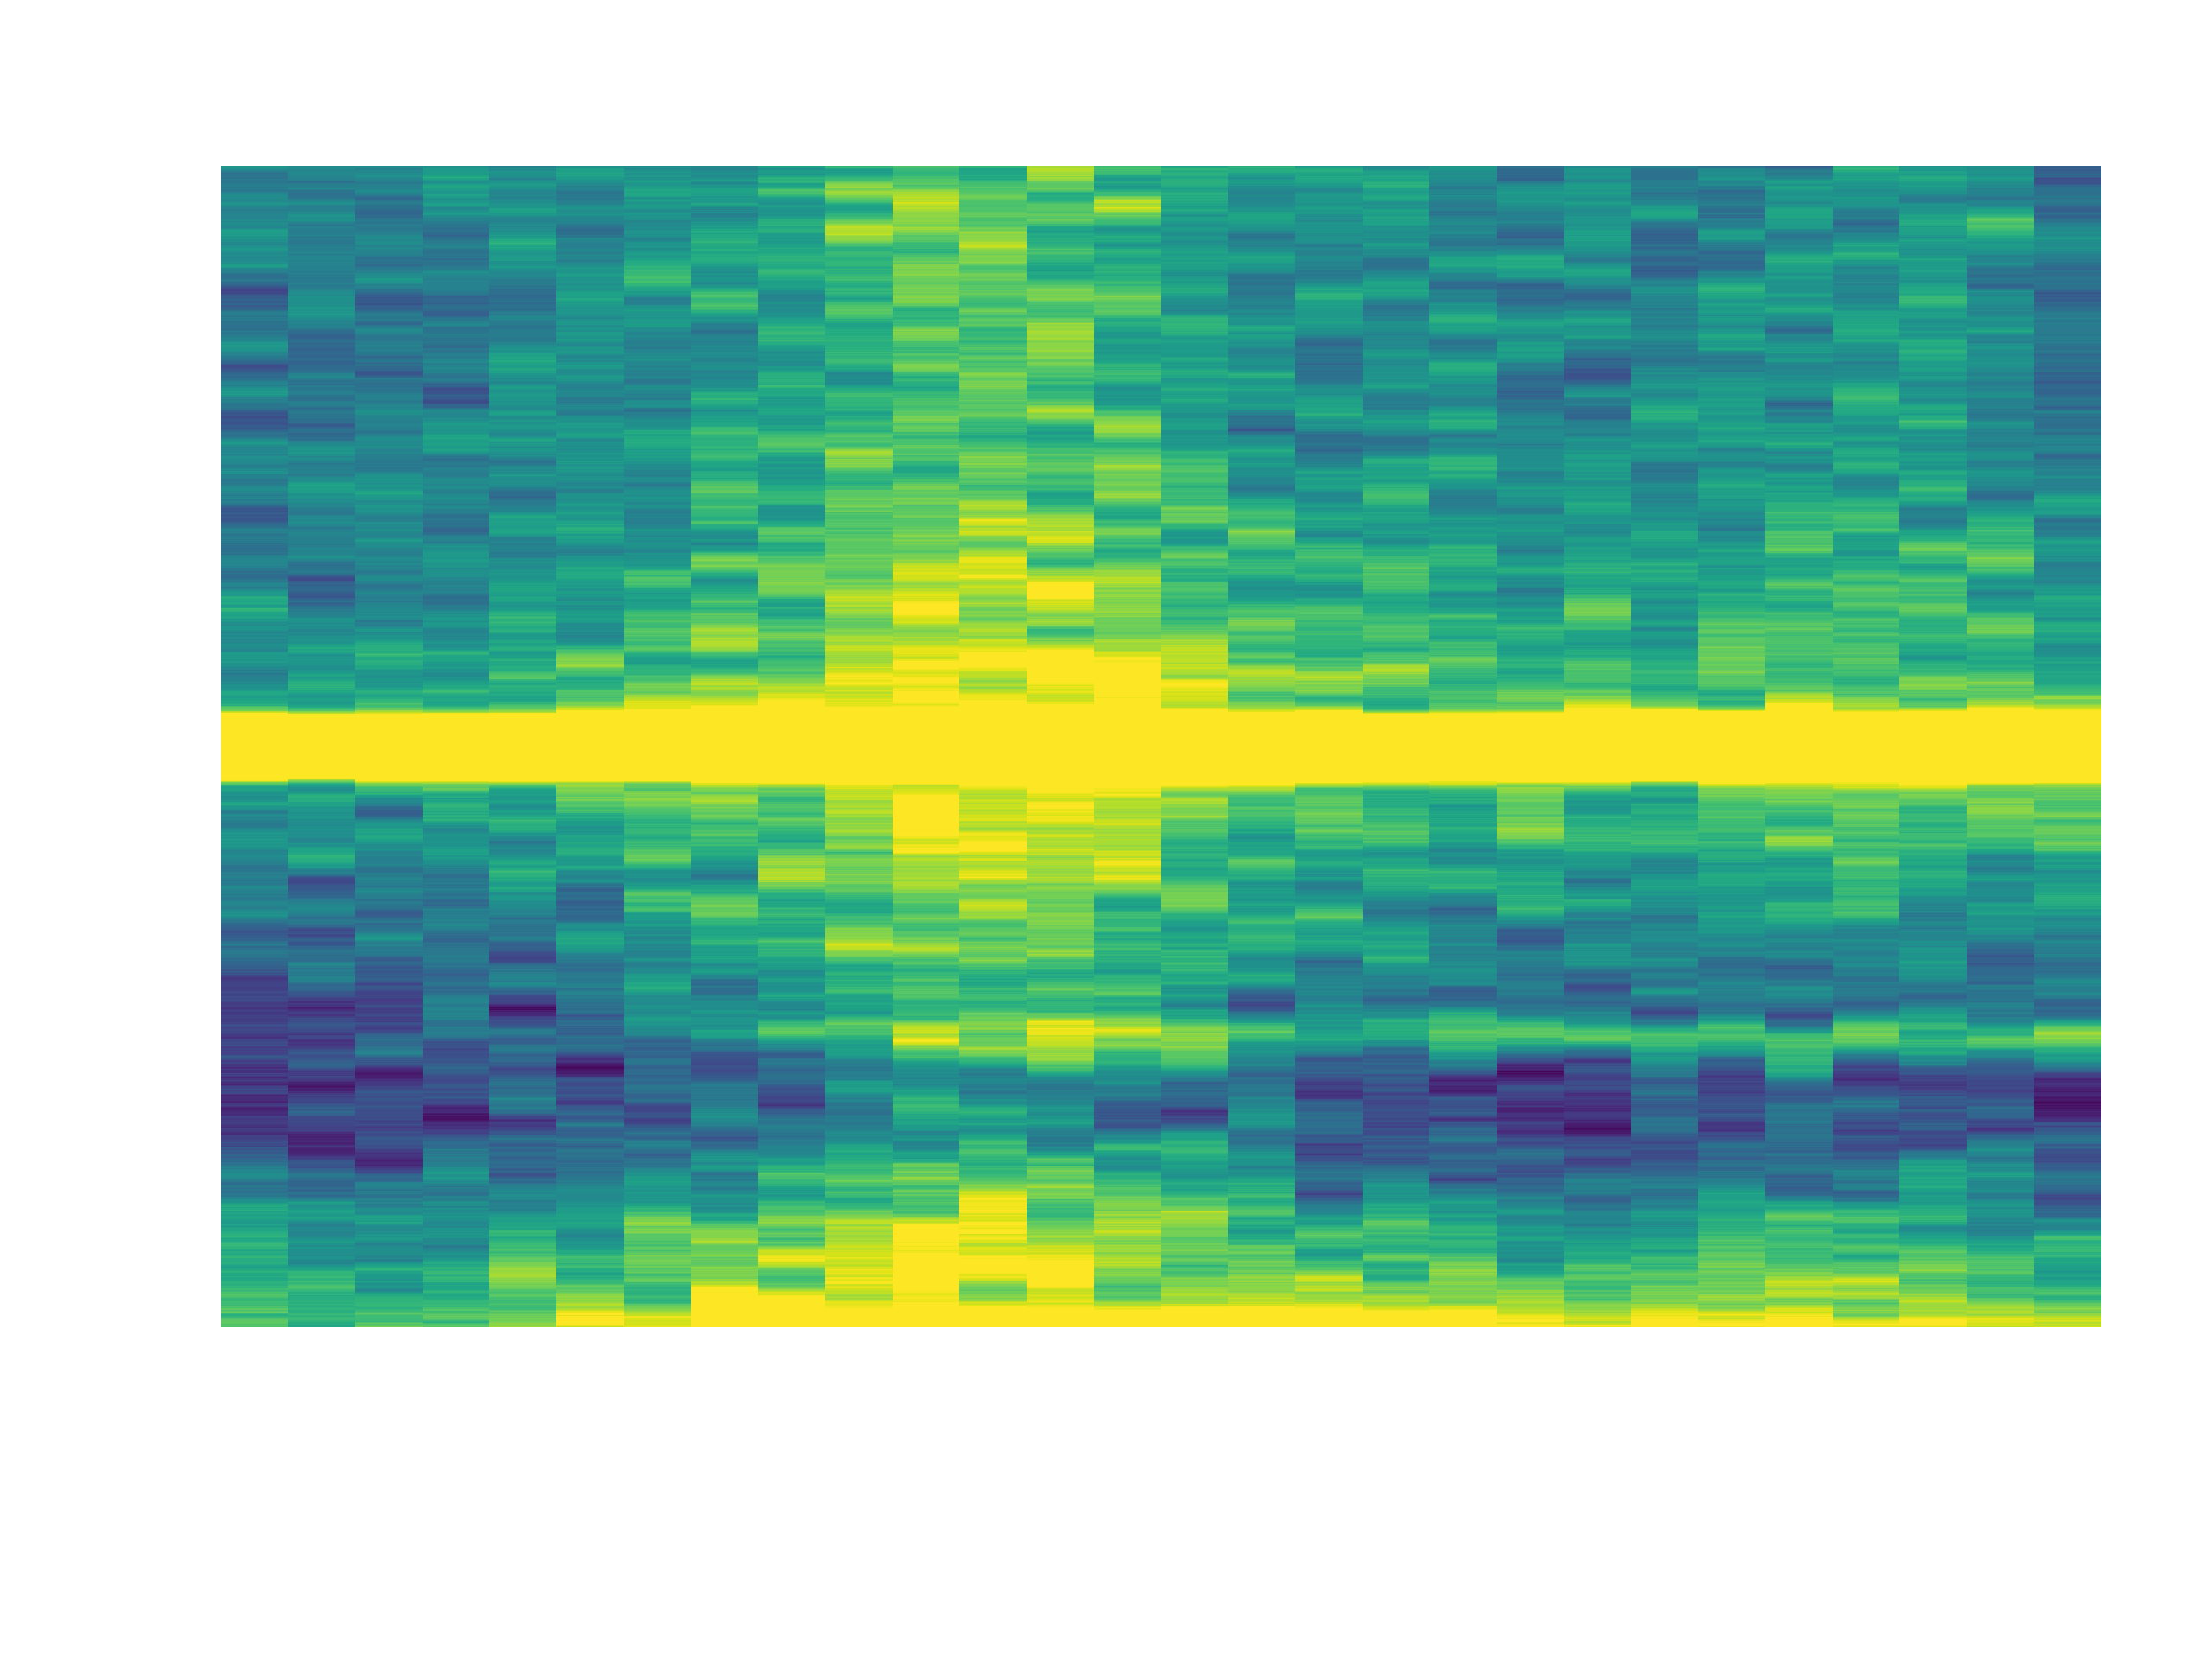

In [75]:
fig = plt.figure(figsize=(8, 6))
# fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(111)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=0.4*10**(-7)
             )
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax.axis('off') 
plt.savefig(FILENAME.replace("txt", "png"), dpi=300, transparent=True, bbox_inches='tight')